<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood_Hessians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     / 10.7MB 2.5MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0516 16:06:52.349010 140557869016960 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:

from tensorflow.contrib.opt import ScipyOptimizerInterface

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [9]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [34]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
grad_opt      = tf.train.GradientDescentOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)


nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#



#### for naive recon and strating MAP finding at truth


### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])

opt_BFGS             = ScipyOptimizerInterface(loss_MAP,method='BFGS')
opt_trust            = ScipyOptimizerInterface(loss_MAP,method='trust-exact')
opt_CG               = ScipyOptimizerInterface(loss_MAP,method='CG')

##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])

num_chains =20

def unnormalized_log_prob(x):
  
  fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

  # option to use uncorrected latent space
  gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

  likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_corr))

  likeli_log_prob_x  = likeli_x.log_prob(x_corr)

  prior_x            = prior.log_prob(x)

  posterior_x        = prior_x+likeli_log_prob_x

  return posterior_x


#### ----- this is an hmc sampler------------#

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)



ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# Initialize the HMC transition kernel.
num_results      = int(2e4)
num_burnin_steps = int(2e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_steps_between_results=10,
    num_burnin_steps=num_burnin_steps,
    current_state=ini_chain,
    kernel=hmc)
#### ----- this is an hmc sampler------------#

#### ----- this is a a Random Walk Metropolis Hastings------------#

# Initial state of the chain
init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# Run Random Walk Metropolis with normal proposal for `num_results`
# iterations for `num_chains` independent chains:
mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_log_prob,
        seed=54,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
    num_burnin_steps=num_burnin_steps,
    num_steps_between_results=10,  # Thinning.
    parallel_iterations=1)


# # # construct a GMM approximation from different minima
num_comp = 2

ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tf.Variable(tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus))

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)

update_c      = sigma_gmmt.assign(tf.cholesky(sigma_est))

#softplus_inverse


gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
gmm_sample_x  =tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

#### optimize on GMM using EL20

gmm_sample    = tf.identity(gmm.sample())
fwd_sample    = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
gen_z         = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_sample), lambda: generator(gmm_sample)),[batch_size2,data_dim,n_channels])

likeli_z      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_corr))

likeli_log_prob_z = likeli_z.log_prob(x_corr)

prior_z       = prior.log_prob(gmm_sample)

posterior_z   = -(prior_z+likeli_log_prob_z)

posterior_gmm = -gmm.log_prob(gmm_sample)

grad_gmm      = tf.gradients(posterior_gmm,gmm_sample)

grad_post     = tf.gradients(posterior_z,gmm_sample)

gradgrad_gmm  = tf.gradients(grad_gmm,gmm_sample)

gradgrad_post = tf.gradients(grad_post,gmm_sample)

el2o          = tf.reduce_mean(tf.square(posterior_gmm-posterior_z))+tf.reduce_mean(tf.square(grad_post[0]-grad_gmm[0]))+tf.reduce_mean(gradgrad_post[0]-gradgrad_gmm[0])

opt_op_el2o   = optimizer.minimize(el2o,var_list=[sigma_gmm, w_gmm, mu_gmm])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:14.098998 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:14.153784 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:14.239424 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:14.889992 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:15.322006 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:15.410879 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:16.634861 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:16.741083 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:17.155238 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:17.254192 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:19.477057 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:19.590811 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:20.696689 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:20.840281 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:21.364892 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:21.514775 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:21.916916 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:22.105836 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:22.214208 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:27.609106 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:27.809153 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:29.752831 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:29.990139 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:30.167274 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:32.433991 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:32.694034 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:32.887275 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:34.456875 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:34.714817 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:34.918313 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:37.519330 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:37.801306 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:38.023450 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


Tensor("MatrixBandPart:0", shape=(1, 2, 10, 10), dtype=float32)
Tensor("Assign_22:0", shape=(1, 2, 10, 10), dtype=float32_ref)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:38.976832 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:39.255410 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:39.843091 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:40.139961 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 16:20:40.384511 140557869016960 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


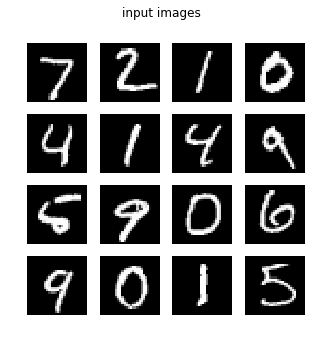

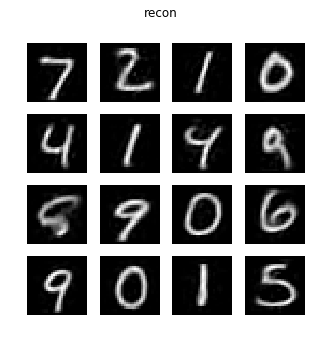

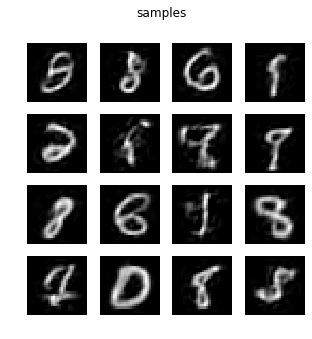

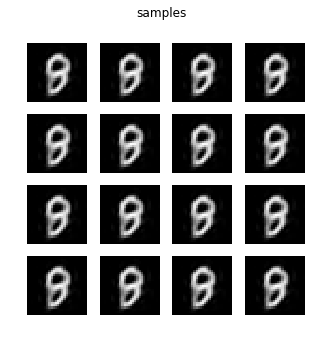

In [13]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:05:08.029361 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


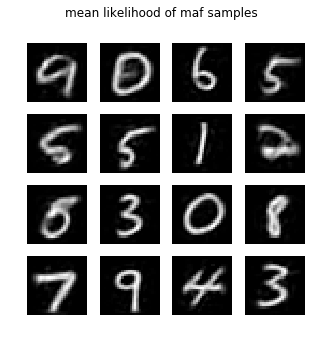

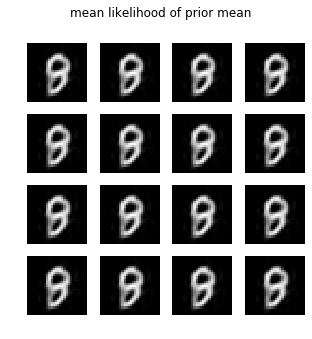

In [29]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


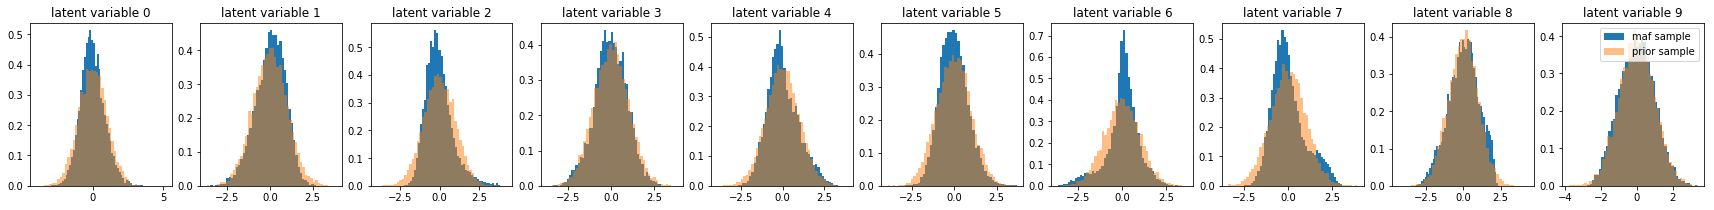

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

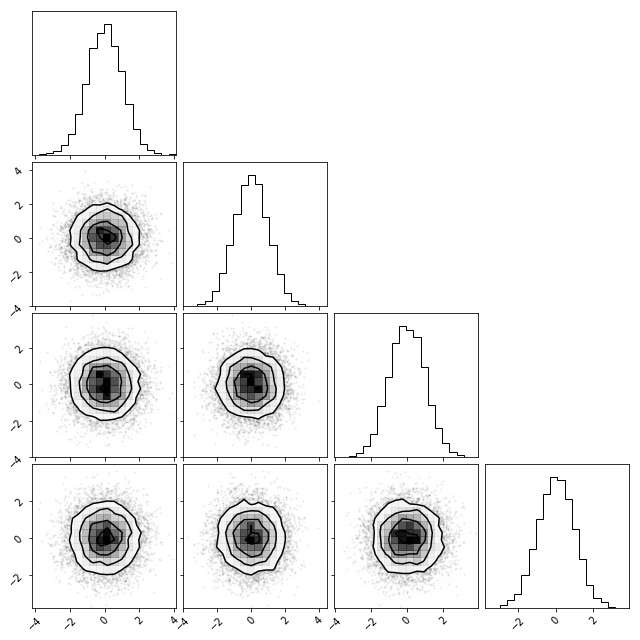

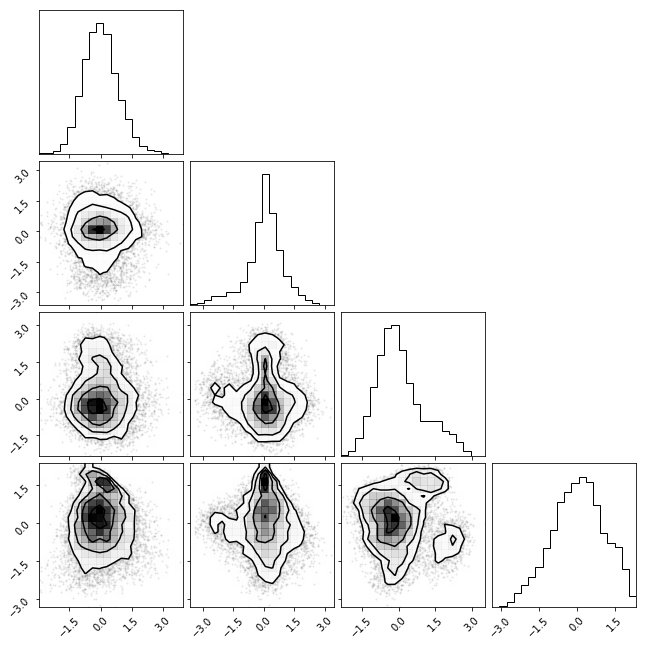

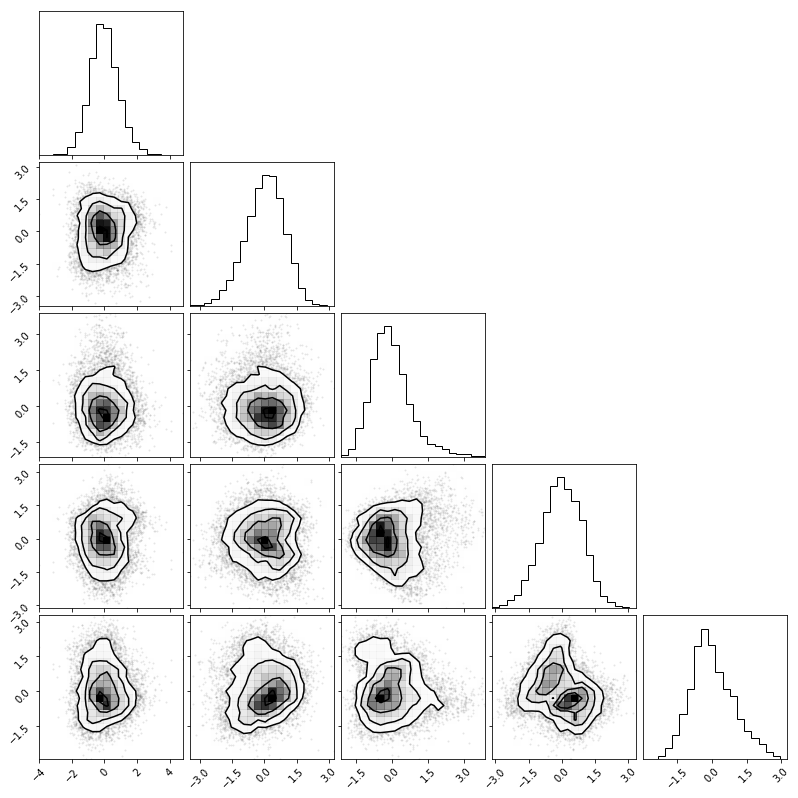

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

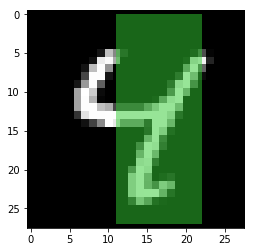

In [79]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 11
maxx = 22
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [29]:
lrate=1e-5
for ii in range(16000):
  if ii >8000:
    lrate=1e-5
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

1693.894
1696.0929
1693.028
1695.516
1699.5219
1701.8044
1696.8915
1692.9963
1694.7426
1694.7432
1695.3431
1697.4376
1697.8002
1691.7605
1692.3821
1705.4315


In [33]:
lrate=1e-20
for ii in range(1000):
  if ii >1000:
    lrate=1e-10
  _, ll = sess.run([grad_opt.minimize(elbo,var_list=[mu_elbo,sigma_elbo]), elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1==0:
    print(ll)

KeyboardInterrupt: ignored

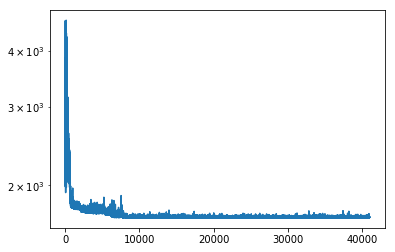

In [31]:
plt.plot(posterior_loss)
yscale('log')

In [37]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

VI_mean, VI_cov = sess.run([approx_posterior_elbo.mean(),approx_posterior_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss     = sess.run(approx_posterior_elbo.log_prob(VI_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss = - VI_min_loss
print(VI_mean,VI_min_loss)

[[ 3.8282645  -0.78783435  0.8812547  -0.61627644  0.7542642   1.8521817
  -1.5651649  -3.6245492   2.4686444  -0.2878965 ]] [-19.134296]


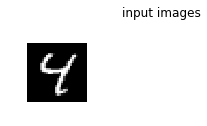

TypeError: ignored

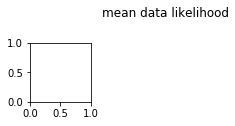

In [33]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVImasked_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  VI_mean, VI_cov, VI_loss = pickle.load(open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except: 
  pickle.dump([VI_mean, VI_cov, VI_min_loss],open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))


B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [93]:
lrate=1e-5
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

1721.465
1728.6616
1722.5568
1722.3137
1724.694
1731.5184
1723.983
1724.3993
1721.6703
1721.1686
1721.4432
1720.5579
1722.9354
1724.6426
1719.8433
1722.0986
1720.6879
1725.7019
1734.3884
1724.2145


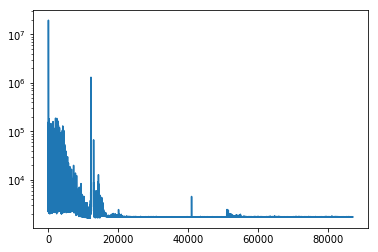

In [91]:
plt.plot(posterior_loss)
yscale('log')

In [92]:
lrate=1e-10
for ii in range(1000):
  if ii >1000:
    lrate=1e-10
  _, ll = sess.run([grad_opt.minimize(elbo_f,var_list=[mu_elbo_f_,sigma_f_elbo]), elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1==0:
    print(ll)

1727.6273
1726.9376
1725.7814
1730.0415
1726.6383
1724.6614
1726.3088
1725.8949
1728.9171
1723.3904


KeyboardInterrupt: ignored

In [94]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_mean, VI_f_cov = sess.run([approx_posterior_f_elbo.mean(),approx_posterior_f_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = sess.run(approx_posterior_f_elbo.log_prob(VI_f_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = -VI_f_min_loss
print(VI_f_mean,VI_f_min_loss)

[[ 4.519319    0.13138086 -2.3007474  -0.5305184   1.924843    1.4704282
   0.78605163 -3.5949123   2.169984    0.6294842 ]] [-15.843215]


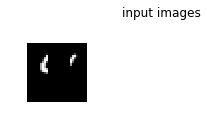

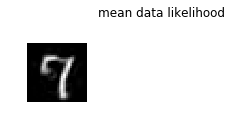

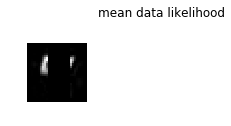

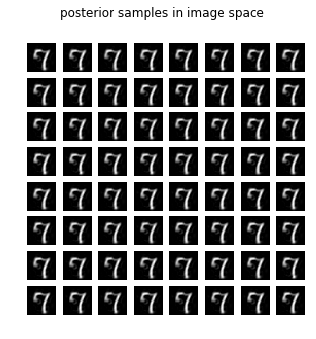

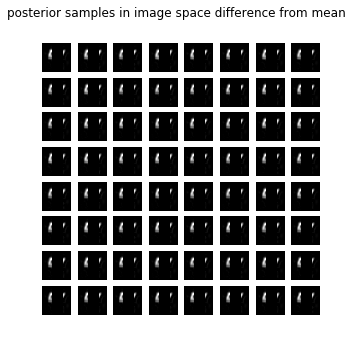

In [95]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samplesmasked_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
try:
  VI_f_mean, VI_f_cov,VI_f_min_loss = pickle.load(open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  
  pickle.dump([VI_f_mean, VI_f_cov,VI_f_min_loss],open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))

**find minima with nvp**

0
2562.6555
1927.7979
1927.8883
1927.8362
1930.6683
1931.0564
1935.3713
1929.7142
1932.9492
1934.8597
1930.0482
1929.6201
1929.7263
1929.8611
1929.6597
1929.7793
1929.6194
1929.605
1929.8645
1929.768
switching to lr 0.001
1929.6166
1929.6041
1929.6014
1929.6066
[[-2.9660529e-01  1.7940552e+00  2.3754675e+00  9.1751270e+00
   1.7758837e+01  9.1931412e+01  3.8825879e+02  5.6100305e+02
   2.0928281e+03  1.3126477e+04]]
1
2302.2317
2310.5234
2094.3406
1978.6594
1959.3392
1959.526
1938.077
1945.1255
1916.0328
1919.7772
1915.023
1914.5964
1914.4762
1914.6025
1914.4288
1914.4521
1914.6279
1914.8827
1914.5125
1914.5645
switching to lr 0.001
1914.6368
1914.4132
1914.4081
1914.3999
[[-1.0279027e+01 -2.8889947e+00  2.3858285e+00  2.2382275e+01
   6.5899681e+01  1.3791641e+02  5.3078387e+02  8.1029395e+02
   4.6925557e+03  1.1236762e+04]]
2
2833.6033
2762.694
2761.929
2762.3472
2761.965
2761.911
2762.452
2762.076
2761.8086
2762.1309
2762.555
2761.3582
2761.1316
2761.1445
2761.1013
2761.209
2761.04

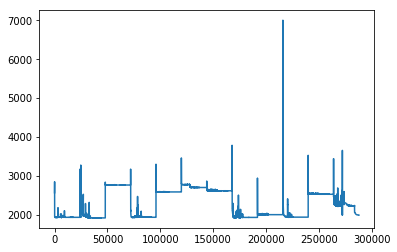

In [80]:
posterior_corr_loss = []
l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
#   for jj in range(3):
#     opt_BFGS.minimize(sess,feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
#     ll=sess.run(loss_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
#     posterior_corr_loss.append(ll)
  lrate=1e-1
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-2
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]
plot(posterior_corr_loss,label='data_loss')

In [98]:
print(pos_def)

[3, 7, 8, 9]


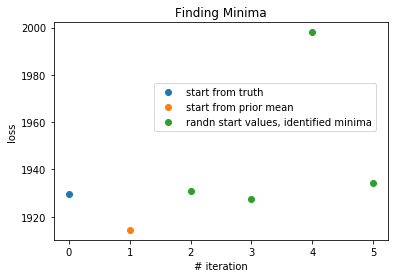

In [97]:
# print(pos_def)
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)
l_minima_pos_def   = l_minima[pos_def]
map_minima_pos_def = map_minima[pos_def]
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(map_minima_pos_def))+2,l_minima_pos_def,ls='',marker='o', label='randn start values, identified minima')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend(loc=(0.3,0.5))
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d_nolbfgs.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima,l_minima_pos_def,map_minima_pos_def, pos_def = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d_nolbfgs.pkl'%(minx,maxx),'rb'))
  #l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima,l_minima_pos_def,map_minima_pos_def,pos_def],open(minima_path+'nvp_minima_xmin%d_xmax%d_nolbfgs.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [63]:
print(map_minima[0])
print(VI_f_mean)
print(VI_mean)

[[[ 2.5158231   0.54948133 -1.4606208   0.6180156   0.6142714
    0.8875758  -0.2298886  -3.6828494   1.2015607  -0.5029857 ]]]
[[ 3.9221215  -0.9864003  -1.6850537  -1.1478671   0.85993564  2.2493565
  -0.57348365 -3.3277936   2.2404249   0.93711597]]
[[ 4.72725     0.21510254 -2.38855    -1.1522334   2.0106003   1.4222734
   0.75022495 -3.7624278   2.1510346   0.5902636 ]]


**Sample posterior of (un)corrupted data**

In [0]:
samples_mcmc, mcmc_stats_ = sess.run([mcmc_samples,mcmc_stats],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

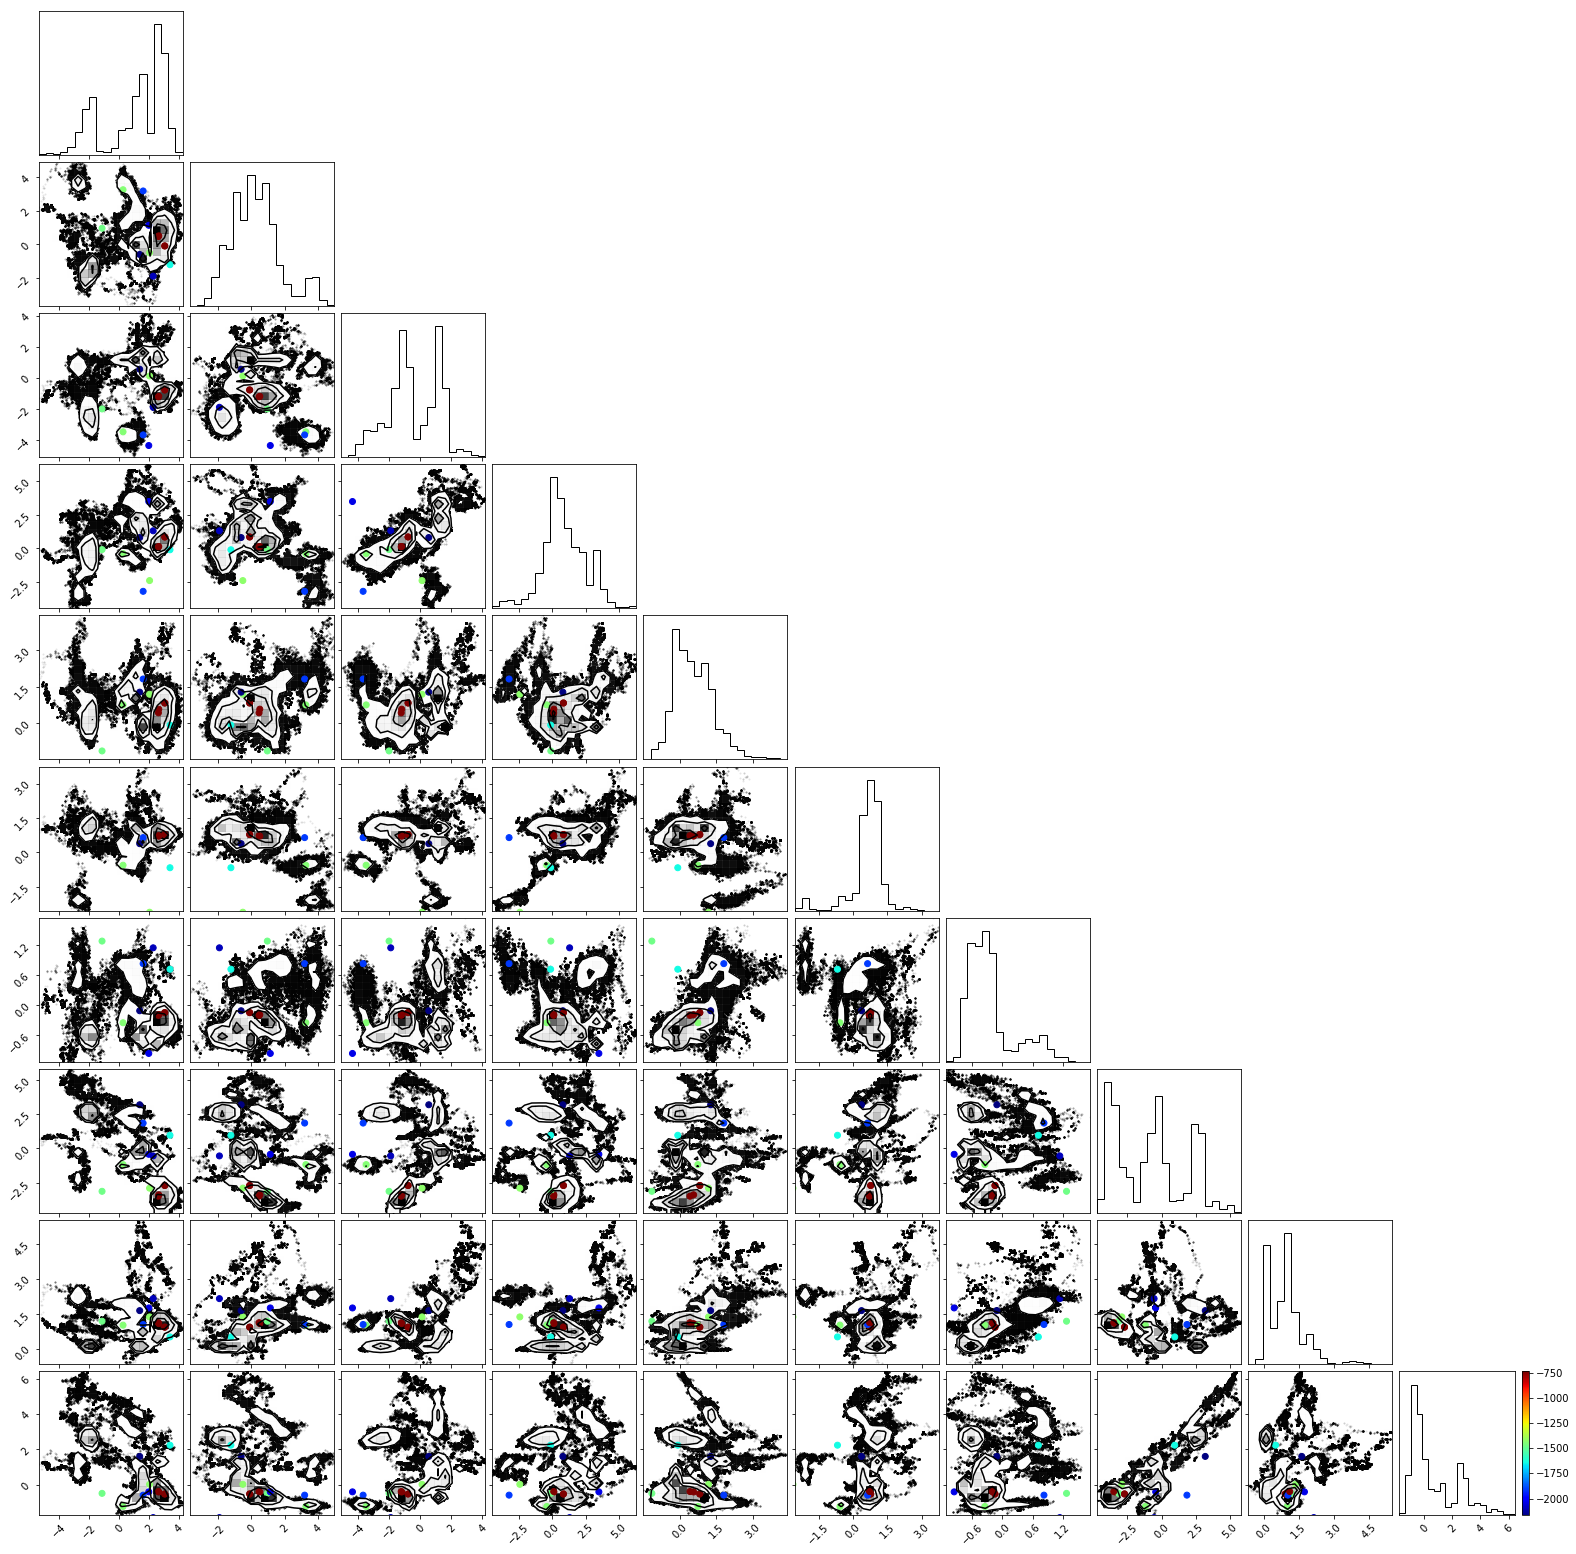

In [123]:
figure = corner.corner(np.reshape(samples_mcmc,[-1,hidden_size]))
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

In [0]:
#corrupted data
samples_, kernel_results_ = sess.run([hmc_samples, hmc_kernel_results],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

In [96]:
samples_.shape
print(max(kernel_results_.accepted_results.target_log_prob.flatten()),-min(l_minima))

-987.4353 -734.68427


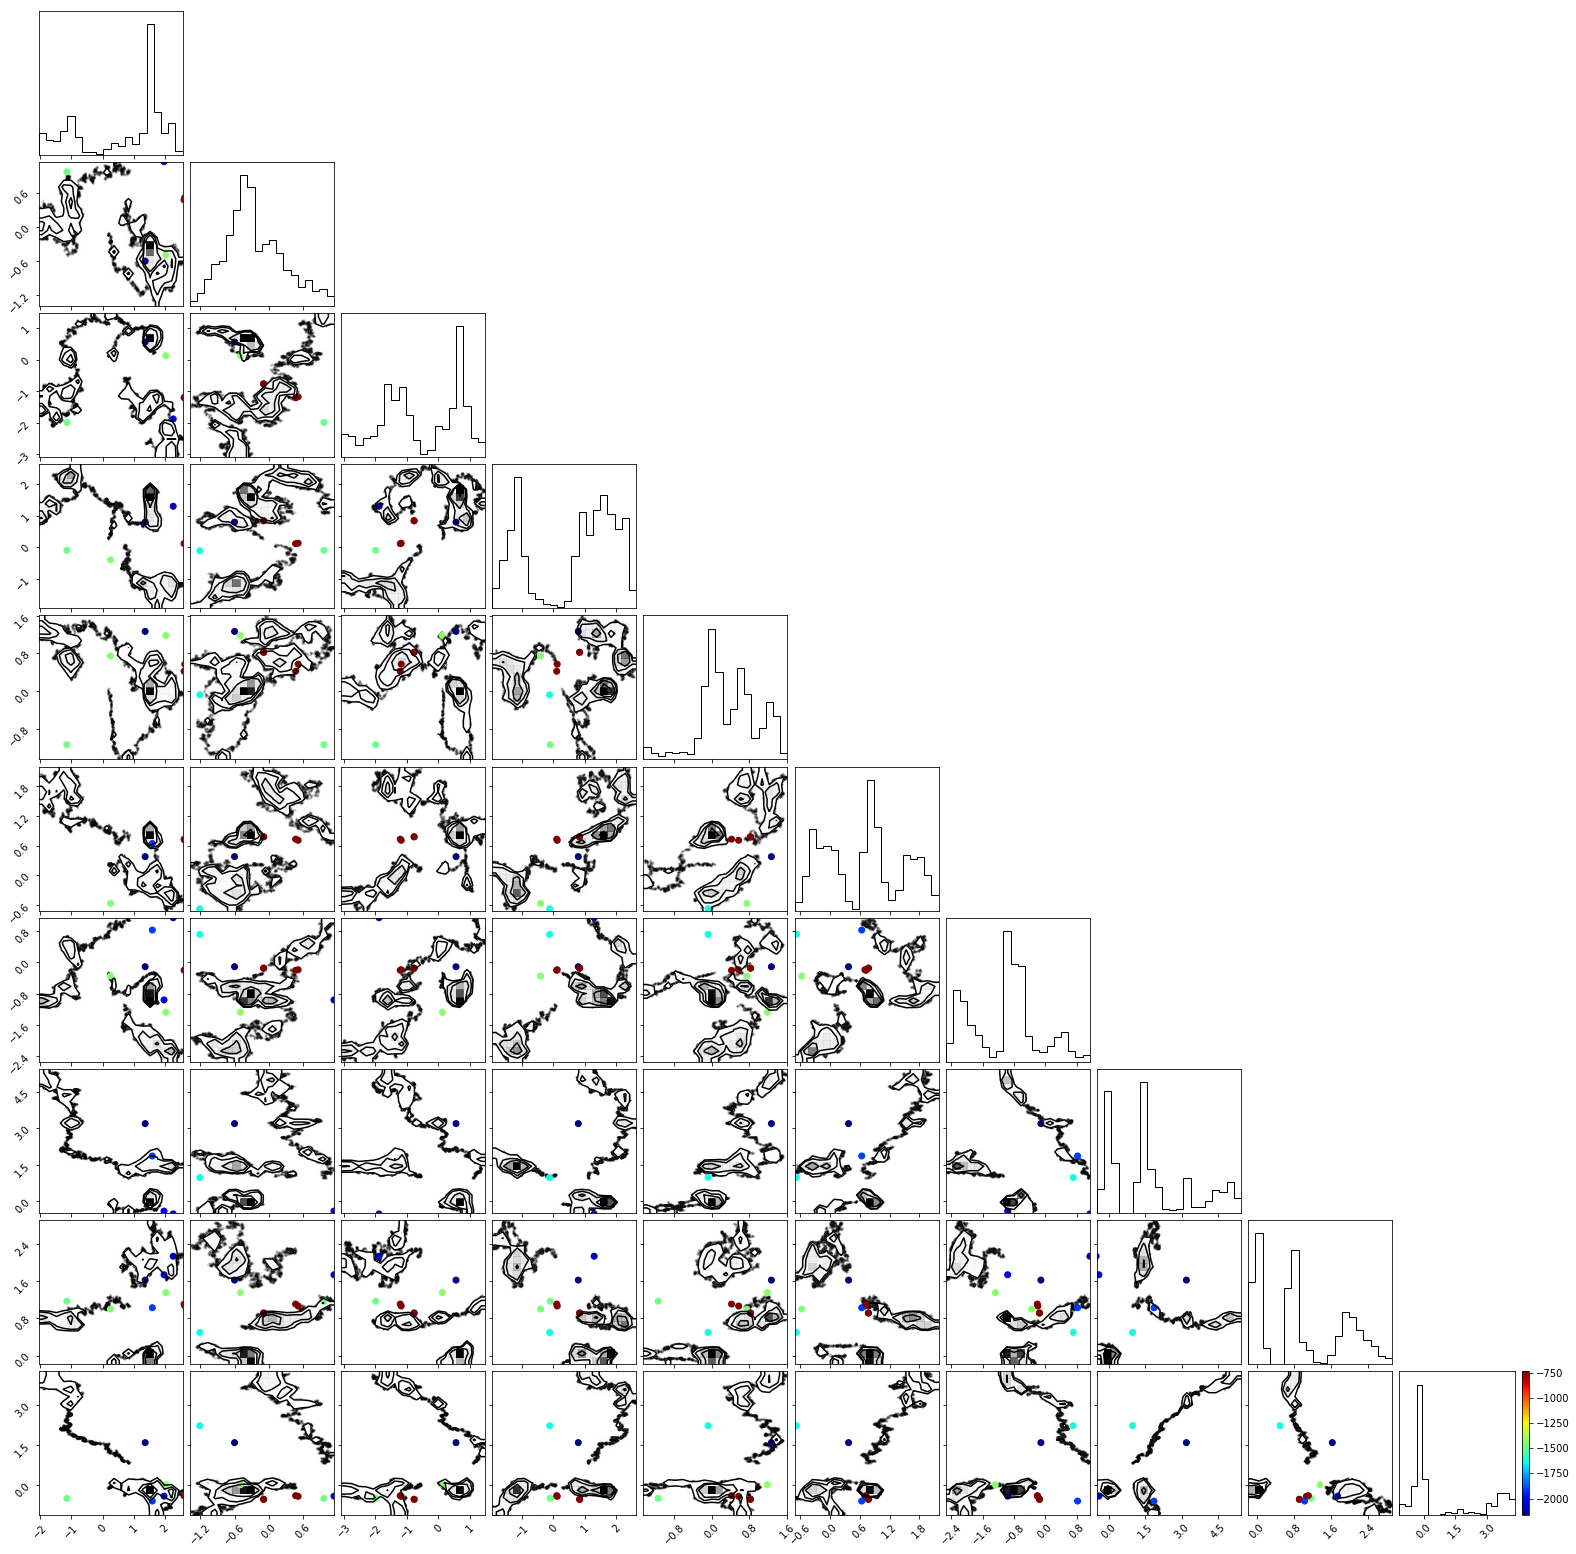

In [111]:
order = np.argsort(l_minima)

figure = corner.corner(np.reshape(samples_,[-1,hidden_size]))#,truths = map_minima_old[order][0,0,0,:])
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

mean:0.1693  stddev:0.9419  acceptance:0.6615


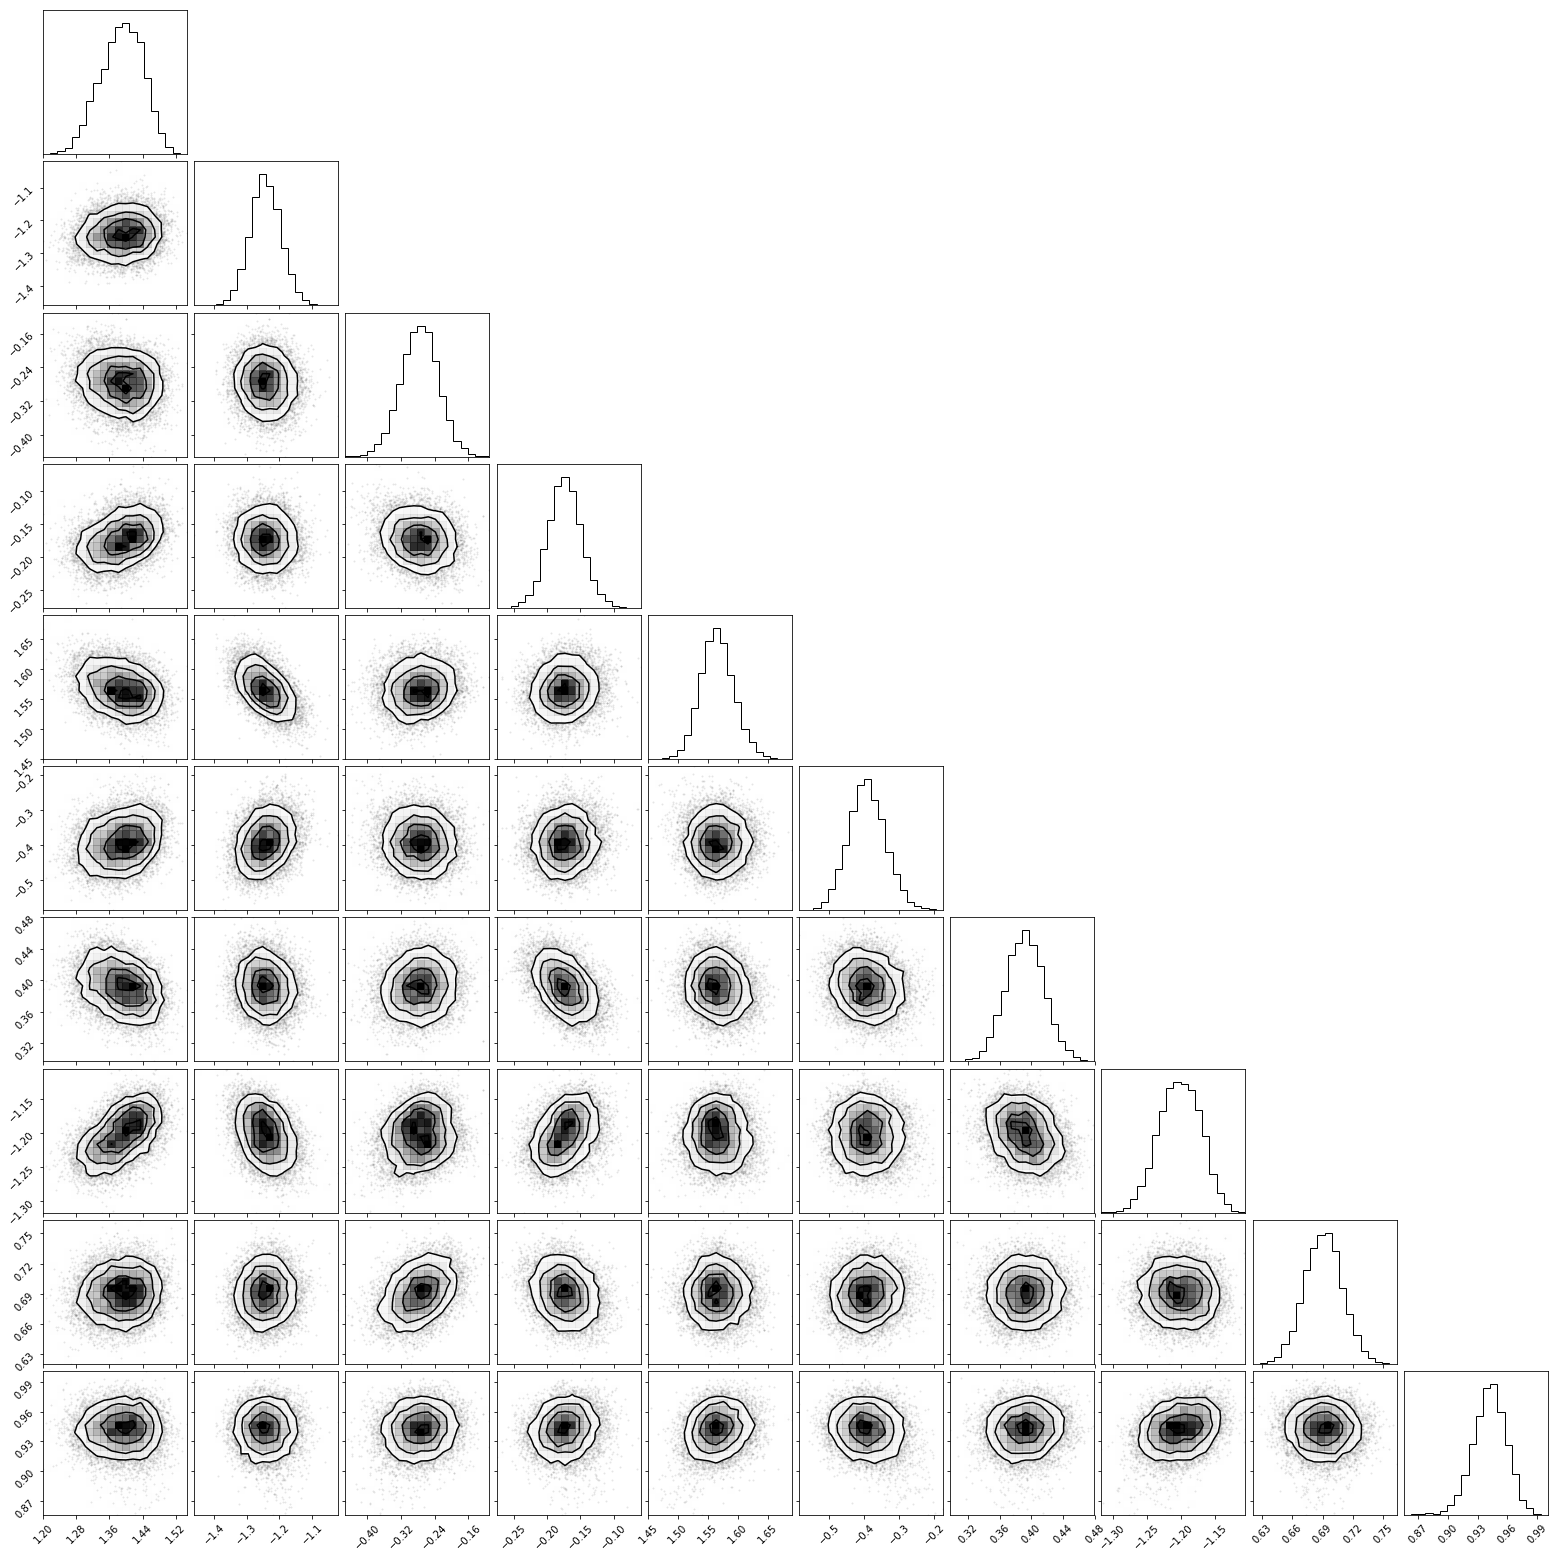

In [16]:
#uncorrupted data
samples_, kernel_results_ = sess.run([samples, kernel_results],feed_dict={x_corr: np.expand_dims(x_true,-1)})
_ = corner.corner(samples_[:,0,:])

In [105]:
data.shape

(1, 784, 1)

**get covariances around minima**

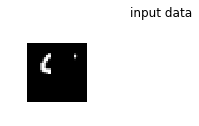

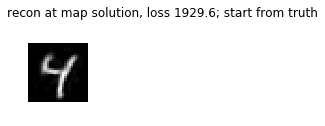

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


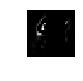

eigenvalues before and after inverse, approx hessian
[array([[9.8290330e-01, 9.9933815e-01, 9.9971116e-01, 1.0000015e+00,
        1.0000345e+00, 1.0002024e+00, 1.0002738e+00, 1.0008523e+00,
        1.0098357e+00, 2.9379028e+05]], dtype=float32), array([[3.40378890e-06, 9.96465333e-01, 9.99272239e-01, 9.99751822e-01,
        9.99900482e-01, 1.00002801e+00, 1.00009181e+00, 1.00020857e+00,
        1.00038590e+00, 1.00332115e+00]])]


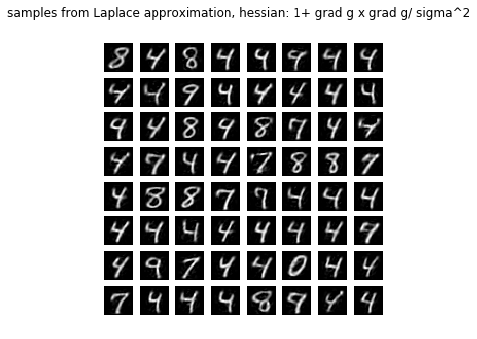

covariances
(1, 10, 10)


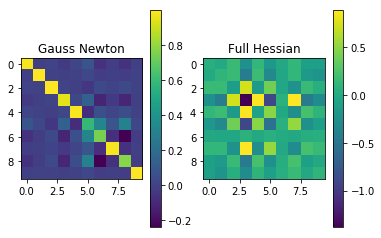

hessians
(1, 10, 10)


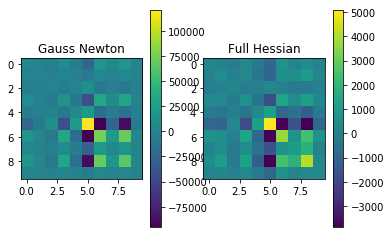

eigenvalues before and after inverse, full hessian
[array([[-2.9660529e-01,  1.7940552e+00,  2.3754675e+00,  9.1751270e+00,
         1.7758837e+01,  9.1931412e+01,  3.8825879e+02,  5.6100305e+02,
         2.0928281e+03,  1.3126477e+04]], dtype=float32), array([[-3.36903058e+00,  7.61818989e-05,  4.77822338e-04,
         1.78252136e-03,  2.57560521e-03,  1.08777184e-02,
         5.63108563e-02,  1.08994037e-01,  4.21036090e-01,
         5.57450514e-01]])]
1
full hessian fails


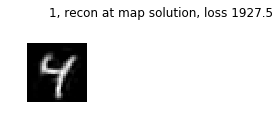

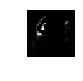

eigenvalues before and after inverse, approx hessian
[array([[9.9720979e-01, 9.9986714e-01, 9.9995267e-01, 9.9998838e-01,
        1.0000007e+00, 1.0000573e+00, 1.0001994e+00, 1.0007466e+00,
        1.0072546e+00, 1.3610697e+05]], dtype=float32), array([[7.34716246e-06, 9.98446484e-01, 9.99559218e-01, 9.99958377e-01,
        9.99996719e-01, 1.00000060e+00, 1.00001243e+00, 1.00004720e+00,
        1.00025847e+00, 1.00077493e+00]])]


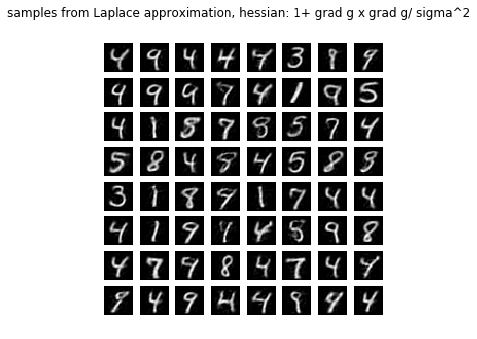

covariances
(1, 10, 10)


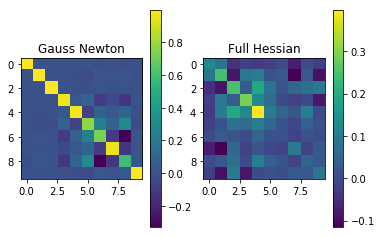

hessians
(1, 10, 10)


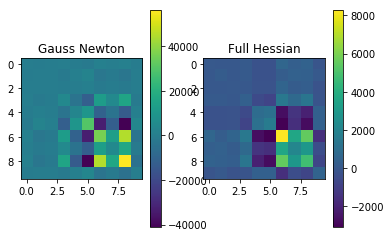

eigenvalues before and after inverse, full hessian
[array([[1.4994704e+00, 2.0129640e+00, 4.0810957e+00, 8.7196856e+00,
        1.8080511e+01, 7.1560829e+01, 1.3138055e+02, 5.0478036e+02,
        1.2926399e+03, 1.7100984e+04]], dtype=float32), array([[5.84761632e-05, 7.73610479e-04, 1.98105927e-03, 7.61145732e-03,
        1.39739377e-02, 5.53076437e-02, 1.14688625e-01, 2.45018379e-01,
        4.96770482e-01, 6.66807832e-01]])]
1


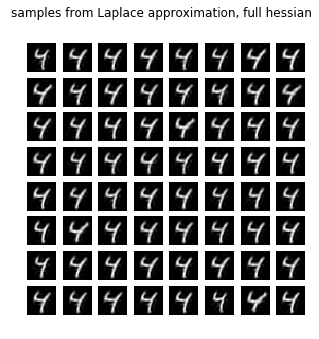

diagonal approx


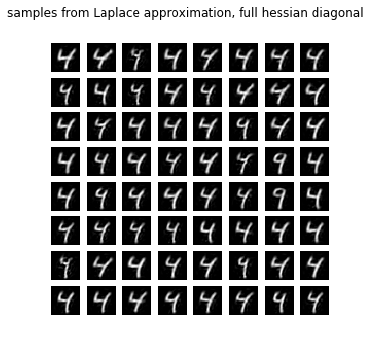

hessian successful 1


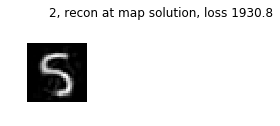

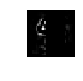

eigenvalues before and after inverse, approx hessian
[array([[9.9790466e-01, 9.9945861e-01, 9.9993306e-01, 9.9997187e-01,
        9.9999350e-01, 1.0000327e+00, 1.0000623e+00, 1.0003226e+00,
        1.0005867e+00, 1.3563630e+05]], dtype=float32), array([[7.37265547e-06, 9.99597214e-01, 9.99744713e-01, 9.99963190e-01,
        9.99999670e-01, 1.00002429e+00, 1.00004332e+00, 1.00004992e+00,
        1.00033938e+00, 1.00068549e+00]])]


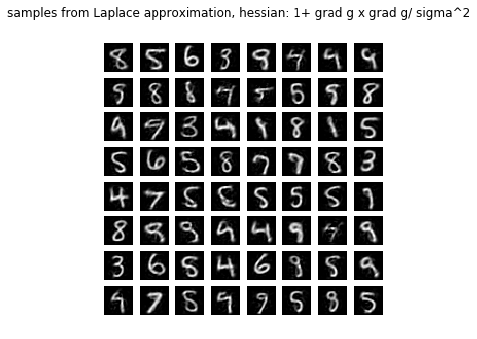

covariances
(1, 10, 10)


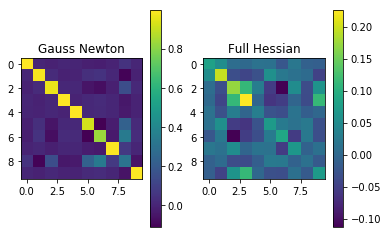

hessians
(1, 10, 10)


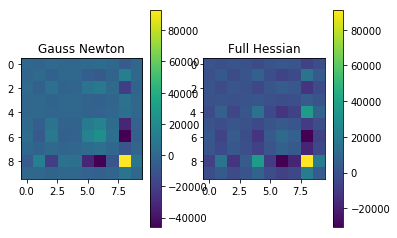

eigenvalues before and after inverse, full hessian
[array([[2.1059294e+00, 4.4160833e+00, 6.1817946e+00, 1.4491768e+01,
        1.7213749e+01, 4.8034279e+01, 2.3774176e+02, 8.2630762e+02,
        1.9695210e+03, 1.3056228e+05]], dtype=float32), array([[7.65917956e-06, 5.07738262e-04, 1.21020550e-03, 4.20633628e-03,
        2.08181394e-02, 5.80914272e-02, 6.90050772e-02, 1.61746301e-01,
        2.26446268e-01, 4.74996514e-01]])]
1


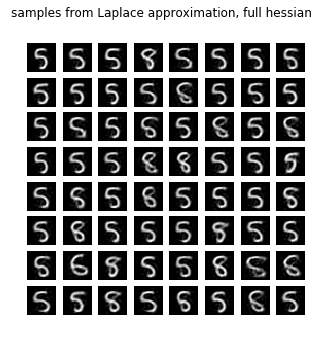

diagonal approx


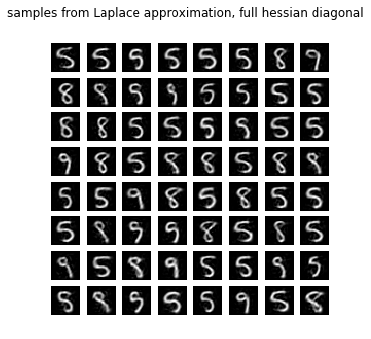

hessian successful 2


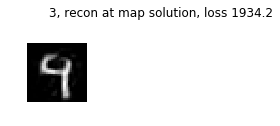

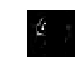

eigenvalues before and after inverse, approx hessian
[array([[9.9759299e-01, 9.9965435e-01, 9.9986428e-01, 9.9997431e-01,
        9.9999440e-01, 1.0000004e+00, 1.0000079e+00, 1.0000569e+00,
        1.0053661e+00, 4.5745703e+04]], dtype=float32), array([[2.18599699e-05, 9.99745472e-01, 9.99924025e-01, 9.99994765e-01,
        9.99996262e-01, 1.00000869e+00, 1.00001655e+00, 1.00008697e+00,
        1.00016026e+00, 1.00051435e+00]])]


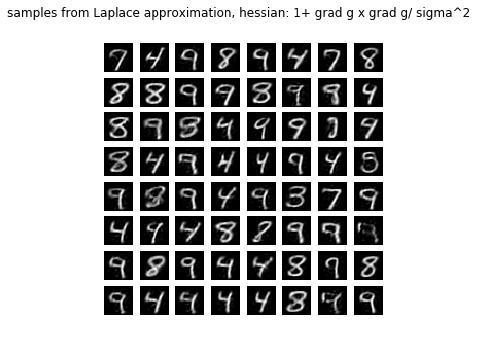

covariances
(1, 10, 10)


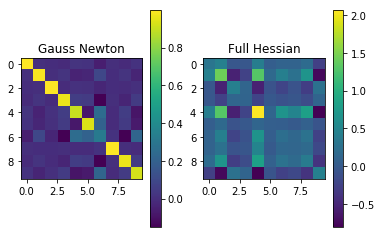

hessians
(1, 10, 10)


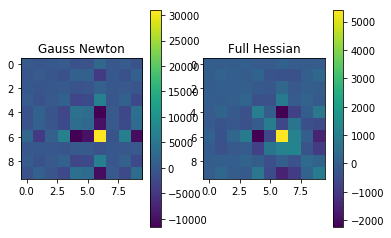

eigenvalues before and after inverse, full hessian
[array([[2.2108264e-01, 1.9206430e+00, 2.6777771e+00, 1.2532892e+01,
        1.7758562e+01, 2.4813091e+01, 1.3880652e+02, 2.8200165e+02,
        2.4674553e+03, 7.4076094e+03]], dtype=float32), array([[1.34996313e-04, 4.05275931e-04, 3.54607599e-03, 7.20428202e-03,
        4.03012223e-02, 5.63115881e-02, 7.97897505e-02, 3.73444871e-01,
        5.20701311e-01, 4.52080866e+00]])]
1


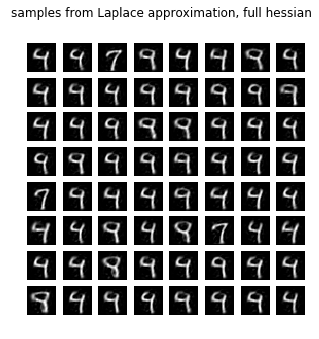

diagonal approx


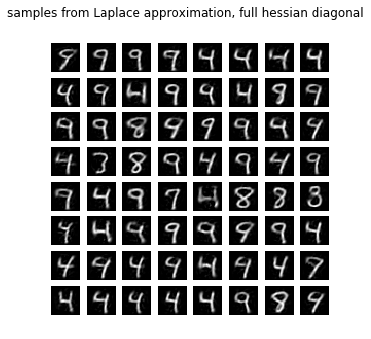

hessian successful 3


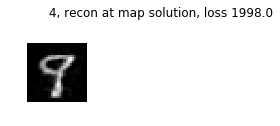

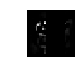

eigenvalues before and after inverse, approx hessian
[array([[9.9878073e-01, 9.9988145e-01, 9.9997991e-01, 9.9999923e-01,
        1.0000011e+00, 1.0000031e+00, 1.0000926e+00, 1.0001479e+00,
        1.0004874e+00, 3.0446834e+04]], dtype=float32), array([[3.28441399e-05, 9.99559914e-01, 9.99800780e-01, 9.99988793e-01,
        9.99995263e-01, 1.00000111e+00, 1.00000118e+00, 1.00002862e+00,
        1.00005268e+00, 1.00016703e+00]])]


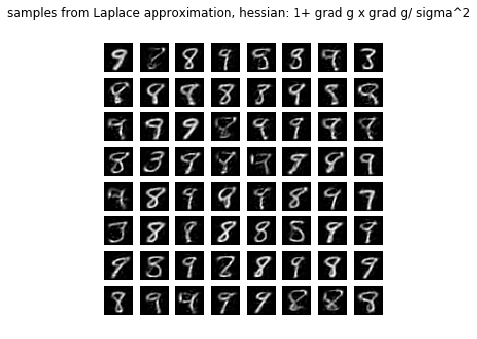

covariances
(1, 10, 10)


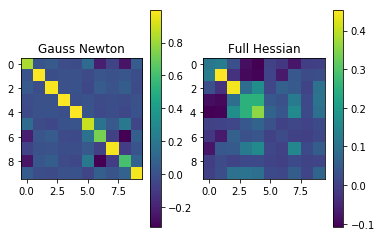

hessians
(1, 10, 10)


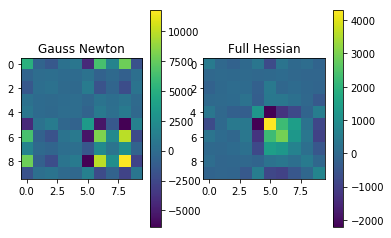

eigenvalues before and after inverse, full hessian
[array([[1.12911689e+00, 2.02582550e+00, 2.82980418e+00, 1.06604080e+01,
        1.58533125e+01, 1.10711975e+02, 3.79110931e+02, 6.49003052e+02,
        1.89069861e+03, 8.08248438e+03]], dtype=float32), array([[1.23724308e-04, 5.28905165e-04, 1.54082426e-03, 2.63775078e-03,
        9.03243911e-03, 6.30776940e-02, 9.38059217e-02, 3.53377799e-01,
        4.93633291e-01, 8.85667513e-01]])]
1


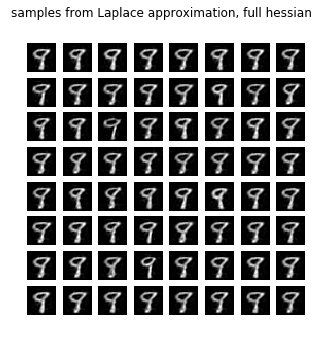

diagonal approx


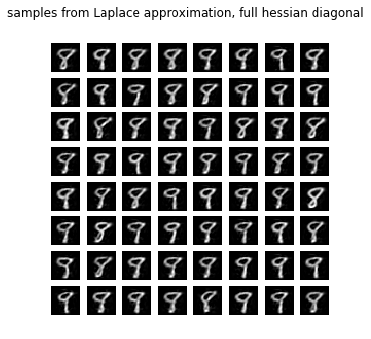

hessian successful 4


In [89]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 

order      = np.argsort(l_minima_pos_def)
results    = np.concatenate((np.expand_dims(map_minima[0],0),map_minima_pos_def[order]), axis=0)
l_results  = np.concatenate((np.expand_dims(l_minima[0],0),l_minima_pos_def[order]), axis=0)
# go through minima
for ii,ini_ in enumerate(results):
  
  
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_results[ii])
  else:
    suptitle('%d, recon at map solution, loss %.1f'%(ii,l_results[ii]))
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
      
      subplot(4,4,i+1)
      imshow(np.reshape((mean_at_map[i,:,0]-data[0,:,0])*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [1]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian diagonal')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
    print('hessian successful',ii)
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


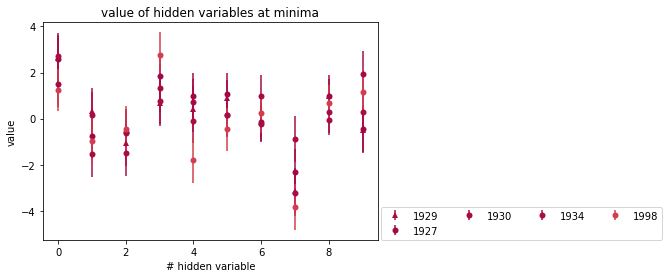

In [90]:
# check if minima are distinct
order = np.argsort(l_minima_pos_def)
map_minima_pos_def = np.asarray(map_minima_pos_def[order])
l_minima_pos_def   = np.asarray(l_minima_pos_def[order])
varis      = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_minima), vmax=max(l_minima))
cmap = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(results)):
  yerr_= np.sqrt(varis[ii,0])
  if ii ==0:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
  else:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d_nolbfgs.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**explore posterior around minima**

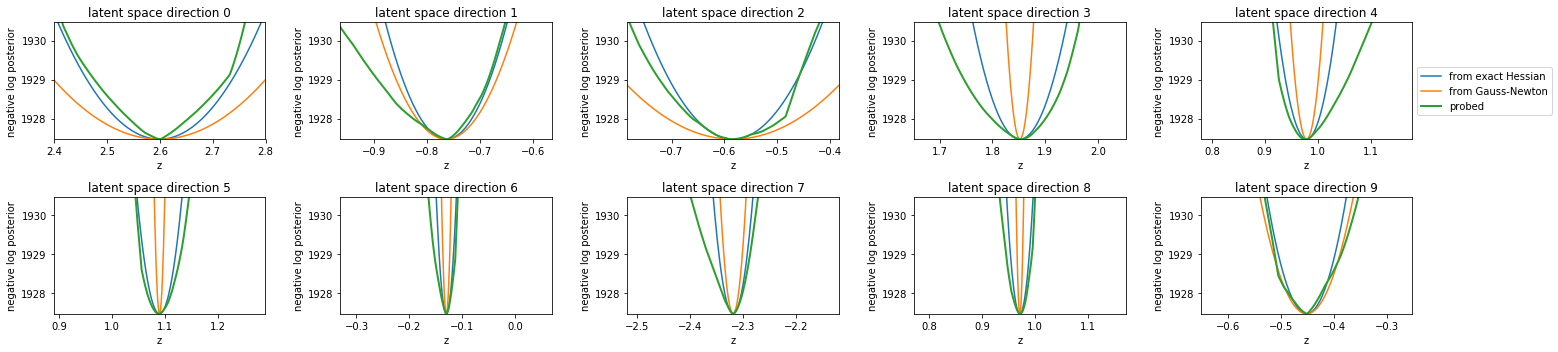

In [91]:
order     = np.argsort(l_minima_pos_def)[0]

# testing Hessian
for ii,ini_ in enumerate([map_minima_pos_def[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
    VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

    z_VI  = (0.001*(np.arange(1001)-501))*VI_mean[0,nn]
    
    VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

    z_VIf = (0.001*(np.arange(1001)-501))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(1001):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.001*(jj-501))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
      

    
    
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+B*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from exact Hessian')
    #plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    #plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+GN*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],losses,label='probed', lw=2)
    
    
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(-ll0,-ll0+3)
#     if nn in [0,1]:
    plt.xlim(ini_[0][:,nn]-0.2, ini_[0][:,nn]+0.2)
#     elif nn in [2,3,4,5,6,9]:
#       plt.xlim(ini_[0][:,nn]-0.1, ini_[0][:,nn]+0.1)
#     elif nn in [7,8]:
#       plt.xlim(ini_[0][:,nn]-0.05, ini_[0][:,nn]+0.05)
  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d_noVI_start0_rescaled_nolbfgs.png'%(minx,maxx),bbox_inches='tight')


**Build Gaussian Mixture Model**

In [96]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]
num_comp= 2# len(l_minima_pos_def)[]
offset =1700 #for numerical stability
mus     = map_minima_pos_def
# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  print(sess.run(MAP_reset,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})]
  

  #diag+=[sess.run(lapl_variance_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  logdet_ = sess.run(log_det,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(logdet_,logprob,0.5*logdet_+logprob)
  w_tilde+=[np.exp(0.5*logdet_+logprob+offset)]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


_=sess.run(update_a,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })



[[ 2.5994475  -0.7632577  -0.58363223  1.8518779   0.97930634  1.0894585
  -0.1302016  -2.3181248   0.9714749  -0.45166788]]
[-39.85580011] [-1927.4692] [-1947.39713834]
[[ 1.4949888  -1.5548168  -0.6084576   1.3386959   0.71177083  0.14683306
   0.9677589  -0.8628788  -0.06615275  1.9309379 ]]
[-44.9959431] [-1930.7935] [-1953.29142858]
[[3.60402656e-108]
 [9.92956570e-111]]
[0.99725244 0.00274756]


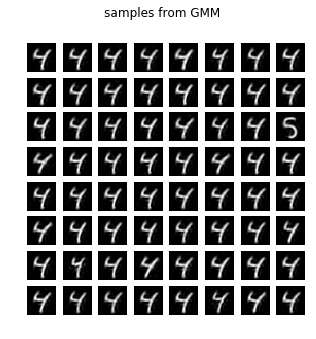

In [95]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()